## A/B Testing 

In [557]:
import random
import pandas as pd
import numpy as np
from pprint import pprint
import scipy.stats as st
import matplotlib.pyplot as plt

In [558]:
def stretch_numbers(num1, num2, n):
    """
    Stretch two numbers into a list of n elements by linear interpolation.
    """
    if n <= 2:
        raise ValueError("n should be greater than 2 for stretching")

    step = (num2 - num1) / (n - 1)  # Calculate the step size for linear interpolation
    stretched_list = [num1 + i * step for i in range(n)]  # Linearly interpolate between num1 and num2
    return stretched_list

In [559]:
def plot_ci(point_estimate, ub, lb):
    x = stretch_numbers(-point_estimate*1.50, point_estimate*1.50, 5)
    y = [1,1,1,1,1]

    x_dmin = list([point_estimate])*5
    y1 = [0,1,2,3,4]

    x_neg_dmin = list([-point_estimate])*5
    y1 = [0,1,2,3,4]

    plt.figure(figsize=(8,4))

    plt.plot(x, y, color = 'white')
    plt.plot(stretch_numbers(0,0,5), stretch_numbers(0,4,5), color = 'black', linestyle='--')
    #plt.plot(x_dmin, y1, color ='red',  linestyle='--')
    #plt.plot(x_neg_dmin, y1, color ='red',  linestyle='--', label = 'Practical Significance Boundary')

    #Plot CI
    plt.plot(stretch_numbers(lb,ub,5), stretch_numbers(2,2,5), color ='blue',  linestyle='-')
    plt.plot(stretch_numbers(lb,lb,5), stretch_numbers(2*.85,2*1.15,5), color ='blue',  linestyle='--')
    plt.plot(stretch_numbers(ub,ub,5), stretch_numbers(2*.85,2*1.15,5), color ='blue',  linestyle='--', label ='Confidence Interval')

    #Adding Point Estimate for 
    plt.scatter(point_estimate, 2, color='green', s=100, label='Point Estimate (d_hat)')

    # Hide y-axis ticks
    plt.yticks([]) 

    plt.title("Practical & Statistical Signifigance Boundaries for Hypothesis Test")
    # Adding legend
    plt.legend(loc='upper right')

    plt.show()

In [562]:
def get_t_crit(dof, alpha):
    t_crit = st.t.ppf(1 - alpha/2, dof)
    return t_crit

## Generating User Data

In [560]:
user_list = []

for i in list(range(1,1500+1)):
    user_id = i
    opens = random.randint(1, 100)
    if i % 2 == 0:
        variant = 'control' # Even 
        purchase_adjust = random.randint(-10, opens) * .95 # Discount control
        if purchase_adjust <= 0:
            purchases = 0
        else:
            purchases = purchase_adjust
    else:
        variant = 'treatment' # Odd
        purchases = random.randint(0, opens) # Discount control

    user = {
        'user_id': user_id,
        'opens': opens,
        'purchases': purchases,
        'variant': variant,
        'purchaser': np.where(purchases >= 1, 1, 0),
        'user': 1 
    }

    user_list.append(user)

df = pd.DataFrame(user_list)    

df['purchase_rate'] = df['purchases'] / df['opens']
df['purchaser_prob'] = df['purchaser'] / df['user']

treatment = df[df['variant'] == 'treatment']

control = df[df['variant'] == 'control']

In [561]:
#Viewing Summary Metrics
df.groupby('variant').agg({'opens': 'sum', 'purchases': 'sum', 'purchase_rate': 'mean', 'purchaser_prob': 'mean'}).reset_index()

,variant,opens,purchases,purchase_rate,purchaser_prob
0,control,38767,16168.05,0.378103,0.741333
1,treatment,37713,18936.00,0.509548,0.96


## Means

Means typically work best when you are summing a continuous metric in the numerator and dividing by the randomization unit. The analysis unit here is typciallly equal to the randomization unit

{'confidence_interval': [1.401642509595768, 5.979557490404239],
 'diff': 3.6906000000000034,
 'mean_c': 21.557399999999998,
 'mean_t': 25.248,
 'n_c': 750,
 'n_t': 750,
 'pooled_std_err': 22.597179151998226,
 'pooled_var': 1.1669133136927277,
 't_crit': 1.9615488687508156,
 't_stat': 3.1627027960808873}


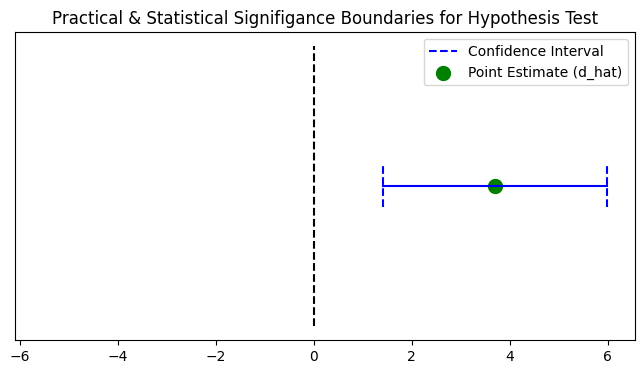

In [563]:
alpha = 0.05 

mean_t = np.mean(treatment.purchases)
mean_c = np.mean(control.purchases)

diff = mean_t - mean_c

n_t = len((treatment.purchases))
n_c = len((control.purchases))

dof = n_t + n_c - 2 

sse_t = np.sum((treatment.purchases - mean_t) ** 2)
sse_c = np.sum((control.purchases - mean_c) ** 2)

pooled_std_err = np.sqrt((sse_t + sse_c) / dof)
pooled_var = pooled_std_err * np.sqrt(1/n_t + 1/n_c)

t = diff / pooled_var

t_crit = get_t_crit(dof, alpha)

moe = pooled_var * t_crit

lb = diff - moe
ub = diff + moe

result = {
    'mean_t': mean_t,
    'mean_c': mean_c,
    'n_t': n_t,
    'n_c': n_c,
    'diff': diff,
    'pooled_std_err': pooled_std_err,
    'pooled_var': pooled_var,
    't_stat': t,
    't_crit': t_crit,
    'confidence_interval': [lb, ub]
}

pprint(result)

plot_ci(diff, ub, lb)


## Proportions

Proportions are used when we want to know the prob of a user/RU taking some action. For example: d7 retention,is_buyer, is_d7_buyer, etc. 

{'confidence_interval': [0.18259231581713906, 0.2547410175161943],
 'diff_prob': 0.21866666666666668,
 'n_c': 750,
 'n_t': 750,
 'pooled_se': 0.01840528104567736,
 'prob_c': 0.7413333333333333,
 'prob_t': 0.96,
 'x_c': 556,
 'x_t': 720,
 'z_crit': 1.96,
 'z_stat': 11.880648066388664}


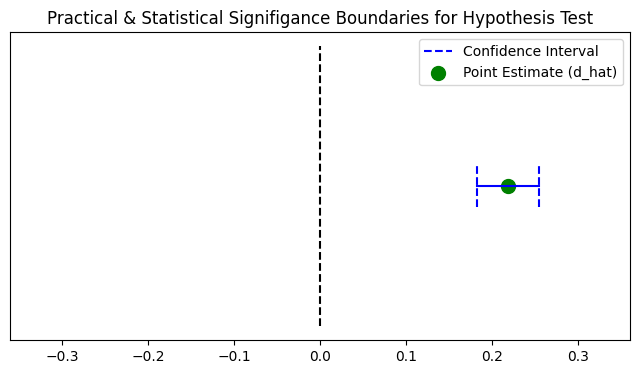

In [564]:
alpha = 0.05 
critical_z = 1.96

prob_t = np.sum(treatment.purchaser) / np.sum(treatment.user)
prob_c = np.sum(control.purchaser) / np.sum(control.user)

diff_prob = prob_t  - prob_c 
p_pool = (np.sum(treatment.purchaser) + np.sum(control.purchaser)) / (np.sum(control.user) + np.sum(treatment.user))

pooled_se = np.sqrt(p_pool * (1-p_pool) * (1/n_t + 1/n_c)) 

z = diff_prob / pooled_se

moe = pooled_se * critical_z

lb = diff_prob - moe
ub = diff_prob + moe

result = {
    'prob_t': prob_t,
    'prob_c': prob_c,
    'x_t': np.sum(treatment.purchaser),
    'x_c': np.sum(control.purchaser),
    'n_t': np.sum(treatment.user),
    'n_c': np.sum(control.user),
    'diff_prob': diff_prob,
    'pooled_se': pooled_se,
    'z_stat': z,
    'z_crit': critical_z,
    'confidence_interval': [lb, ub]
}

pprint(result)

plot_ci(diff_prob, ub, lb)

## Ratios

Ratio metrics are metrics like: CTR, Purchase Rate, View Rate, etc. The idea is that the analysis unit (AU) is different from the randomization unit (RU). The RU is typically a user_id but in case like purchase rate the RU is a menu open (purchases / menu opens). In cases like this we can use the delta method to calculate the variance as outlined here: https://medium.com/@ahmadnuraziz3/applying-delta-method-for-a-b-tests-analysis-8b1d13411c22 . This is also mentioned and derived in TOCE

In [565]:
#variance estimation of metrics ratio
def var_ratio(x,y): #x/y
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    var_x = np.var(x,ddof=1)
    var_y = np.var(y,ddof=1)
    cov_xy = np.cov(x,y,ddof=1)[0][1]
    result = (var_x/mean_x**2 + var_y/mean_y**2 - 2*cov_xy/(mean_x*mean_y))*(mean_x*mean_x)/(mean_y*mean_y*len(x))
    return result

{'confidence_interval': [0.04977307990270785, 0.12032890683013886],
 'rate_c': 0.41705703304356795,
 'rate_diff': 0.08505099336642336,
 'rate_t': 0.5021080264099913,
 'std_err': 0.035277913463715505,
 't_stat': 4.725334653639483,
 'var': 0.000323961676997449}


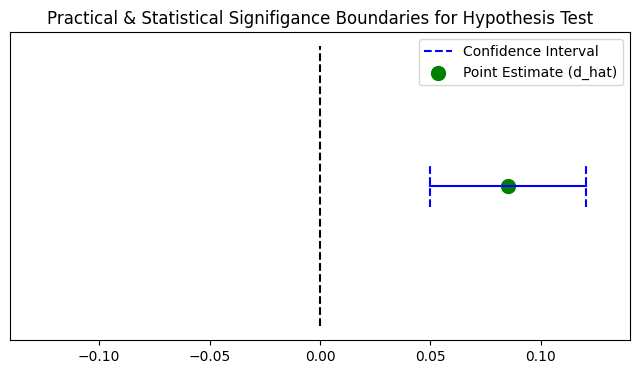

In [566]:
alpha = 0.05
t_crit = 1.96 

rate_t = np.sum(treatment.purchases) / np.sum(treatment.opens)
rate_c = np.sum(control.purchases) / np.sum(control.opens)

rate_diff = rate_t - rate_c

var_t = var_ratio(treatment.purchases, treatment.opens) 
var_c = var_ratio(control.purchases, control.opens) 

var = var_t + var_c 
stde = 1.96 * np.sqrt(var)

lb = rate_diff - stde 
ub = rate_diff + stde
t = rate_diff/np.sqrt(var)

result = {
    'rate_t': rate_t,
    'rate_c': rate_c,   
    'rate_diff': rate_diff,
    'var': var,
    'std_err': stde,
    't_stat': t,
    'confidence_interval': [lb, ub]
}

pprint(result)

plot_ci(rate_diff, ub, lb)